In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from ink_detection_utils import load_dataset
from ink_detection_utils import get_crop_numer_list
from ink_detection_utils import stitch_crops
from ink_detection_utils import load_volumes

from PIL import Image
from typing import Dict, List, Optional, Tuple
from pathlib import Path
from collections import OrderedDict

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [28]:
#UNet Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

import random

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

In [111]:
# test_img_1 = '../../Datasets/vesuvius-challenge-ink-detection/train/1/inkLabels.png'
# test_img_2 = '../../Datasets/vesuvius-challenge-ink-detection/train/1/ir.png'
#
# image_1 = Image.open(test_img_1)
# image_2 = Image.open(test_img_2)

In [112]:
# transform = transforms.Compose([
#     transforms.RandomCrop(4000),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
# ])

In [113]:
# seed = np.random.randint(2147483647) # make a seed with numpy generator
# random.seed(seed) # apply this seed to img tranfsorms
# torch.manual_seed(seed) # needed for torchvision 0.7
#
# transformed_image_1 = transform(image_1)

In [114]:
# random.seed(seed) # apply this seed to target tranfsorms
# torch.manual_seed(seed) # needed for torchvision 0.7
#
# transformed_image_2 = transform(image_2)

In [115]:
# plt.imshow(transformed_image_1, cmap="gray") #last [] is the layer
# plt.axis("off")
# plt.show()

In [116]:
# plt.imshow(transformed_image_2, cmap="gray") #last [] is the layer
# plt.axis("off")
# plt.show()

In [5]:
VESUVIUS_DATA_PATH = '../../Datasets/vesuvius-challenge-ink-detection/train/'

In [171]:
volume_paths = [VESUVIUS_DATA_PATH+'1/surface_volume/',VESUVIUS_DATA_PATH+'2/surface_volume/',VESUVIUS_DATA_PATH+'3/surface_volume/']
seg_paths = [VESUVIUS_DATA_PATH+'1/inkLabels.png',VESUVIUS_DATA_PATH+'2/inkLabels.png',VESUVIUS_DATA_PATH+'3/inkLabels.png']
mask_paths = [VESUVIUS_DATA_PATH+'1/mask.png',VESUVIUS_DATA_PATH+'2/mask.png',VESUVIUS_DATA_PATH+'3/mask.png']

voxel_size = (24, 512, 512)

In [172]:
class FragmentDataset(Dataset):
    def __init__(self, fragments: List[Path], voxel_shape: Tuple[int, int, int],load_inklabels: bool = True,filter_edge_pixels: bool = False,):

        self.fragments = sorted(map(lambda path: path.resolve(), fragments))
        self.voxel_shape = voxel_shape
        self.load_inklabels = load_inklabels
        self.filter_edge_pixels = filter_edge_pixels

        # Load sequentially
        labels = []
        image_stacks = []
        valid_pixels = []
        for fragment_id, fragment_path in enumerate(self.fragments):
            fragment_path = fragment_path.resolve()  # absolute path
            mask = np.array(Image.open(str(fragment_path / "mask.png")).convert("1"))

            surface_volume_paths = sorted(
                (fragment_path / "surface_volume").rglob("*.tif")
            )
            z_dim, y_dim, x_dim = voxel_shape

            z_mid = len(surface_volume_paths) // 2
            z_start, z_end = z_mid - z_dim // 2, z_mid + z_dim // 2

            # we don't convert to torch since it doesn't support uint16
            images = [
                np.array(Image.open(fn)) for fn in surface_volume_paths[z_start:z_end]
            ]
            image_stack = np.stack(images, axis=0)
            image_stacks.append(image_stack)

            pixels = np.stack(np.where(mask == 1), axis=1).astype(np.uint16)
            if filter_edge_pixels:
                height, width = mask.shape
                mask_y = np.logical_or(
                    pixels[:, 0] < y_dim // 2, pixels[:, 0] >= height - y_dim // 2
                )
                mask_x = np.logical_or(
                    pixels[:, 1] < x_dim // 2, pixels[:, 1] >= width - x_dim // 2
                )
                pixel_mask = np.logical_or(mask_y, mask_x)
                pixels = pixels[~pixel_mask]
            # encode fragment ID
            fragment_ids = np.full_like(pixels[:, 0:1], fragment_id)
            pixels = np.concatenate((pixels, fragment_ids), axis=1)
            valid_pixels.append(pixels)

            if load_inklabels:
                # binary mask can be stored as np.bool
                inklabels = np.array(Image.open(str(fragment_path / "inklabels.png")))
                labels.append(inklabels)

            print(f"Loaded fragment {fragment_path} on {os.getpid()}")

        self.labels = labels
        self.image_stacks = image_stacks
        self.pixels = np.concatenate(valid_pixels).reshape(
            -1, valid_pixels[0].shape[-1]
        )

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        center_y, center_x, fragment_id = self.pixels[index]
        z_dim, y_dim, x_dim = self.voxel_shape
        image_stack = self.image_stacks[fragment_id]
        _, height, width = image_stack.shape
        labels = self.labels[fragment_id]

        # pad with zeros if necessary
        if (
            center_y < y_dim // 2
            or center_x < x_dim // 2
            or center_y + y_dim // 2 >= height
            or center_x + x_dim // 2 >= width
        ):
            # calculate the upper-left corner of the sub-volume
            y_start = max(center_y - y_dim // 2, 0)
            x_start = max(center_x - x_dim // 2, 0)

            # calculate the lower-right corner of the sub-volume
            y_end = min(center_y + y_dim // 2, height)
            x_end = min(center_x + x_dim // 2, width)

            subvolume = np.zeros(self.voxel_shape, dtype=np.float32)
            inklabel = np.zeros(self.voxel_shape, dtype=np.float32)

            pad_y_start = max(y_dim // 2 - center_y, 0)
            pad_x_start = max(x_dim // 2 - center_x, 0)

            pad_y_end = min(height + y_dim // 2 - center_y, y_dim)
            pad_x_end = min(width + x_dim // 2 - center_x, x_dim)

            subvolume[:, pad_y_start:pad_y_end, pad_x_start:pad_x_end] = (
                image_stack[:, y_start:y_end, x_start:x_end].astype(np.float32) / 65535
            )

            if self.load_inklabels:
                inklabel[:, pad_y_start:pad_y_end, pad_x_start:pad_x_end] = (
                    labels[y_start:y_end, x_start:x_end].astype(np.float32)
                )
            else:
                inklabel = np.ones(self.voxel_shape, dtype=np.float32)*-1

        else:
            subvolume = (
                image_stack[
                    :,
                    center_y - y_dim // 2 : center_y + y_dim // 2,
                    center_x - x_dim // 2 : center_x + x_dim // 2,
                ]
            ).astype(np.float32) / 65535

            if self.load_inklabels:
                inklabel = (
                    labels[
                        center_y - y_dim // 2 : center_y + y_dim // 2,
                        center_x - x_dim // 2 : center_x + x_dim // 2,
                    ]
                ).astype(np.float32)
            else:
                inklabel = np.ones(self.voxel_shape, dtype=np.float32)*-1


        return torch.from_numpy(subvolume), torch.FloatTensor(inklabel).unsqueeze(0)

    def plot_label(self, index, **kwargs):
        pixel = self.pixels[index]
        label = self.labels[pixel[-1]]

        print("Index:", index)
        print("Pixel:", pixel)

        if isinstance(label, torch.Tensor):
            label = label.numpy()

        fig, ax = plt.subplots(**kwargs)
        ax.imshow(label, cmap="gray")

        y, x, _ = pixel
        _, y_dim, x_dim = self.voxel_shape
        x_min = x - (x_dim // 2)
        x_max = x + (x_dim // 2)
        y_min = y - (y_dim // 2)
        y_max = y + (y_dim // 2)

        rect = plt.Rectangle(
            (x_min, y_min), x_dim, y_dim, linewidth=2, edgecolor="y", facecolor="none"
        )
        ax.add_patch(rect)
        plt.show()

In [173]:
base_path = Path("../../Datasets/vesuvius-challenge-ink-detection/")
train_path = base_path / "train"
all_fragments = sorted([f.name for f in train_path.iterdir()])
print("All fragments:", all_fragments)
# Due to limited memory on Kaggle, we can only load 1 full fragment
train_fragments = [train_path / fragment_name for fragment_name in ['1']]
train_fragments

All fragments: ['1', '2', '3']


[WindowsPath('../../Datasets/vesuvius-challenge-ink-detection/train/1')]

In [174]:
%%time
train_dset = FragmentDataset(fragments=train_fragments, voxel_shape=voxel_size, filter_edge_pixels=True)
print("Num items (pixels)", len(train_dset))

Loaded fragment D:\MSc - Birmingham\MSc Project\Datasets\vesuvius-challenge-ink-detection\train\1 on 26620
Num items (pixels) 28208880
Wall time: 9.96 s


Index: 14104440
Pixel: [3829 3131    0]


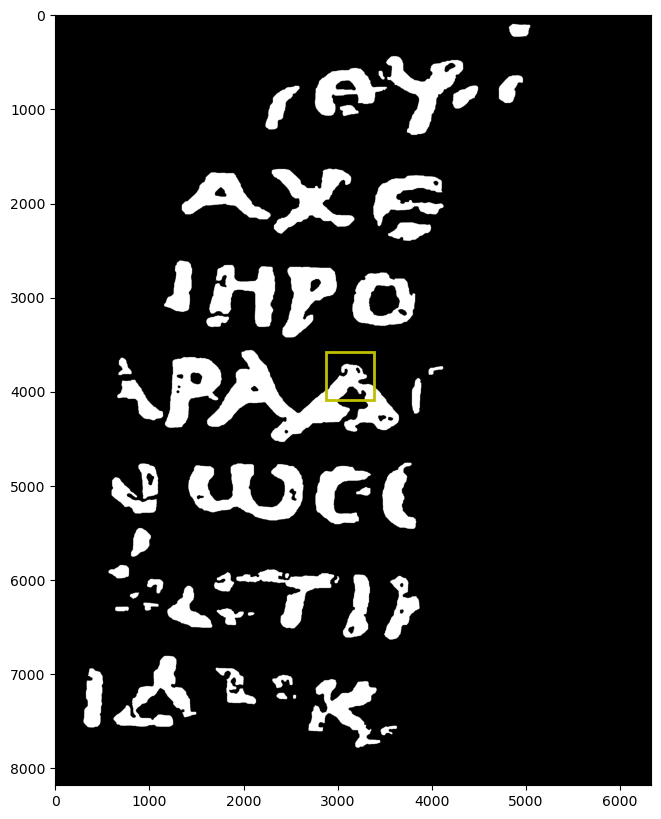

In [175]:
idx = 28208880//2
train_dset.plot_label(idx, figsize=(16, 10))

In [176]:
# Get an item from the dataset
volume, label = train_dset[idx]

# Print the shapes
print("Volume shape:", volume.shape)
print("Segment shape:", label.shape)

Volume shape: torch.Size([24, 512, 512])
Segment shape: torch.Size([1, 512, 512])


In [177]:
volume[0]

tensor([[0.6743, 0.6939, 0.7021,  ..., 0.1436, 0.1329, 0.1280],
        [0.5255, 0.5349, 0.5245,  ..., 0.3035, 0.3037, 0.3034],
        [0.3625, 0.3479, 0.3627,  ..., 0.4517, 0.4608, 0.4517],
        ...,
        [0.6082, 0.5892, 0.5671,  ..., 0.5454, 0.4937, 0.4494],
        [0.6047, 0.6090, 0.6061,  ..., 0.4876, 0.4505, 0.4309],
        [0.6461, 0.6442, 0.6517,  ..., 0.4798, 0.4602, 0.4420]])

In [178]:
val_fragments = [train_path / fragment_name for fragment_name in ['3']]
val_dset = FragmentDataset(fragments=val_fragments, voxel_shape=voxel_size, filter_edge_pixels=True)

Loaded fragment D:\MSc - Birmingham\MSc Project\Datasets\vesuvius-challenge-ink-detection\train\3 on 26620


Index: 17560000
Pixel: [5213 1972    0]


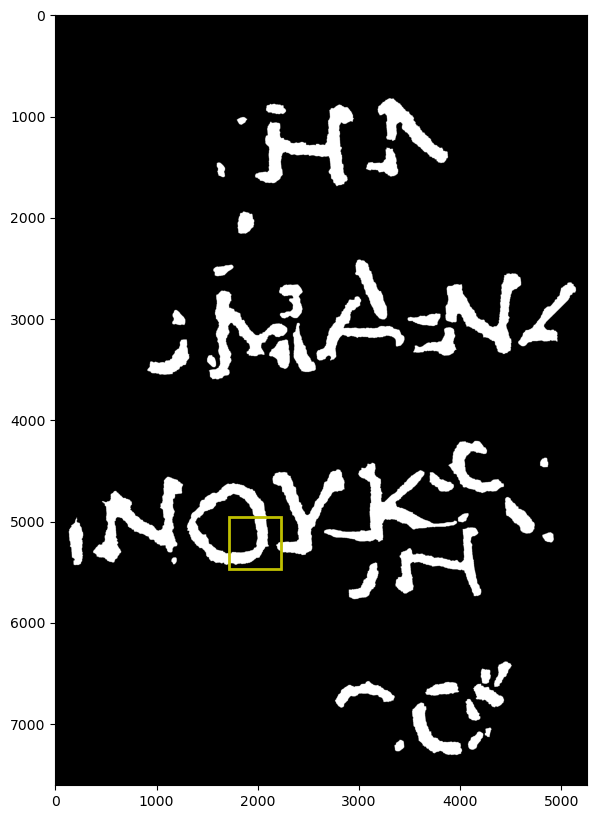

In [179]:
idx = 17560000
val_dset.plot_label(idx, figsize=(16, 10))

In [180]:
# test_path = base_path / "test"
# all_fragments = sorted([f.name for f in test_path.iterdir()])
# print("All fragments:", all_fragments)
# # Due to limited memory on Kaggle, we can only load 1 full fragment
# test_fragments = [test_path / fragment_name for fragment_name in ['a']]
# test_dset = FragmentDataset(fragments=val_fragments, voxel_shape=voxel_size, filter_edge_pixels=True, load_inklabels=False)

In [110]:
# class FragmentDataset(Dataset):
#     def __init__(self, volume_paths, seg_paths, mask_paths, transform=None):
#         self.volume_paths = volume_paths
#         self.seg_paths = seg_paths
#         self.mask_paths = mask_paths
#         self.transform = transform
#
#     def __len__(self):
#         return len(self.volume_paths)
#
#     def __getitem__(self, idx):
#         volume_path = self.volume_paths[idx]
#         seg_path = self.seg_paths[idx]
#         mask_path = self.mask_paths[idx]
#
#         image_paths = [os.path.join(volume_path, file) for file in os.listdir(volume_path) if file.endswith('.tif')]
#
#         volume = []
#
#         seed = np.random.randint(2147483647) # make a seed with numpy generator
#
#         for image_path in image_paths:
#             image = Image.open(image_path)
#             if self.transform is not None:
#
#                 random.seed(seed)
#                 torch.manual_seed(seed)
#
#                 image = self.transform(image)
#             image_array = np.array(image)
#             volume.append(image_array)
#
#         volume = np.stack(volume)
#
#         volume = torch.from_numpy(volume.reshape(volume.shape[0],volume.shape[2],volume.shape[3]))
#
#
#
#         seg = np.array(Image.open(seg_path))
#         if self.transform is not None:
#
#             random.seed(seed)
#             torch.manual_seed(seed)
#
#             seg = self.transform(seg)
#
#         mask = np.array(Image.open(mask_path))
#         if self.transform is not None:
#
#             random.seed(seed)
#             torch.manual_seed(seed)
#
#             mask = self.transform(mask)
#
#
#         return volume ,seg, mask

In [105]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomCrop(70),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
# ])
#
# # Create an instance of the FragmentDataset with the transformations
# frag_data = FragmentDataset(volume_paths, seg_paths, mask_paths, transform=transform)

In [106]:
# # Get an item from the dataset
# idx = 0
# volume, seg, mask = frag_data[idx]
#
# # Print the shapes
# print("Volume shape:", volume.shape)
# print("Segment shape:", seg.shape)
# print("Mask shape:", mask.shape)

In [107]:
# plt.imshow(volume[0], cmap="gray") #last [] is the layer
# plt.axis("off")
# plt.show()

In [108]:
# plt.imshow(seg[0], cmap="gray")
# plt.axis("off")
# plt.show()

In [109]:
# plt.imshow(mask[0], cmap="gray")
# plt.axis("off")
# plt.show()

In [184]:
#Simple UNet Model without skip connections. Works with 512x512 image size

class UNetWithoutSkipConnections(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob):
        super(UNetWithoutSkipConnections, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),#512x512x16
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), #512x512x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #256x256x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),#256x256x32
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), #256x256x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #128x128x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),#128x128x64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #128x128x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),#64x64x128
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #64x64x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32x128

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),#32x32x256
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #32x32x256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #16x16x256

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),#16x16x512
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #16x16x512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #8x8x512

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),#8x8x1024
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), #8x8x1024
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #4x4x1024
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), #4x4x1024
            nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2),#8x8x1024
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), #8x8x512
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),#16x16x512
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), #16x16x256
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),#32x32x256
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),#32x32x128
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),#64x64x128
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),#64x64x64
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2), #128x128x64
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#128x128x32
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2), #256x256x32
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),#256x256x16
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2), #512x512x16
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1), #512x512x1
            nn.Sigmoid()
        )

    def forward(self, x):
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        #print(x.shape)
        return x

In [109]:
# class UNet(nn.Module):
#
#     def __init__(self, in_channels=3, out_channels=1, init_features=32):
#         super(UNet, self).__init__()
#
#         features = init_features
#         self.encoder1 = UNet._block(in_channels, features, name="enc1")
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder2 = UNet._block(features, features * 2, name="enc2")
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
#
#         self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")
#
#         self.upconv4 = nn.ConvTranspose2d(
#             features * 16, features * 8, kernel_size=2, stride=2
#         )
#         self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
#         self.upconv3 = nn.ConvTranspose2d(
#             features * 8, features * 4, kernel_size=2, stride=2
#         )
#         self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
#         self.upconv2 = nn.ConvTranspose2d(
#             features * 4, features * 2, kernel_size=2, stride=2
#         )
#         self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
#         self.upconv1 = nn.ConvTranspose2d(
#             features * 2, features, kernel_size=2, stride=2
#         )
#         self.decoder1 = UNet._block(features * 2, features, name="dec1")
#
#         self.conv = nn.Conv2d(
#             in_channels=features, out_channels=out_channels, kernel_size=1
#         )
#
#     def forward(self, x):
#         enc1 = self.encoder1(x)
#         print(enc1.shape)
#         enc2 = self.encoder2(self.pool1(enc1))
#         print(enc2.shape)
#         enc3 = self.encoder3(self.pool2(enc2))
#         print(enc3.shape)
#         enc4 = self.encoder4(self.pool3(enc3))
#         print(enc4.shape)
#
#         #bottleneck = self.bottleneck(self.pool4(enc4))
#         #print(bottleneck.shape)
#
#         #dec4 = self.upconv4(bottleneck)
#         #dec4 = torch.cat((dec4, enc4), dim=1)
#         #dec4 = self.decoder4(dec4)
#         dec3 = self.upconv3(enc4)
#         #dec3 = torch.cat((dec3, enc3), dim=1)
#         dec3 = self.decoder3(dec3)
#         dec2 = self.upconv2(dec3)
#         #dec2 = torch.cat((dec2, enc2), dim=1)
#         dec2 = self.decoder2(dec2)
#         dec1 = self.upconv1(dec2)
#         #dec1 = torch.cat((dec1, enc1), dim=1)
#         dec1 = self.decoder1(dec1)
#         return torch.sigmoid(self.conv(dec1))
#
#     @staticmethod
#     def _block(in_channels, features, name):
#         return nn.Sequential(
#             OrderedDict(
#                 [
#                     (
#                         name + "conv1",
#                         nn.Conv2d(
#                             in_channels=in_channels,
#                             out_channels=features,
#                             kernel_size=3,
#                             padding=1,
#                             bias=False,
#                         ),
#                     ),
#                     (name + "norm1", nn.BatchNorm2d(num_features=features)),
#                     (name + "relu1", nn.ReLU(inplace=True)),
#                     (
#                         name + "conv2",
#                         nn.Conv2d(
#                             in_channels=features,
#                             out_channels=features,
#                             kernel_size=3,
#                             padding=1,
#                             bias=False,
#                         ),
#                     ),
#                     (name + "norm2", nn.BatchNorm2d(num_features=features)),
#                     (name + "relu2", nn.ReLU(inplace=True)),
#                 ]
#             )
#         )

In [185]:
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [186]:
model = UNetWithoutSkipConnections(in_channels=voxel_size[0], out_channels=1, dropout_prob=0.1)
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1
batch_size = 32

best_test_loss = float('inf')

train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in range(num_epochs):

    # Training
    model.train()

    batch_no = 1

    test_loss = 0.0

    for batch in train_loader:

        train_loss = 0.0

        print('Epoch',epoch,'Processing Batch No:', batch_no, '/',len(train_loader))

        images, labels= batch[0].to(device), batch[1].to(device)

        # Forward pass
        reconstructions = model(images)
        loss = criterion(reconstructions, labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        batch_no = batch_no + 1

        if batch_no%100==0:
            torch.save(model, '../models/temp_ink_detection_simple_u_net_middle_layer_epoch_new_dataset_impl_'+str(num_epochs)+'_batch_'+str(batch_size)+'.pt')

        train_loss /= batch_size

        if batch_no%10==0:

            test_loss = 0.0

            # Evaluation
            model.eval()
            with torch.no_grad():
                val_batch_no = 0

                for batch in val_loader:

                    if val_batch_no == 1:
                        break

                    images, labels = batch[0].to(device), batch[1].to(device)


                    reconstructions = model(images)
                    loss = criterion(reconstructions, labels.float())

                    test_loss += loss.item() * images.size(0)

                    val_batch_no += 1


                test_loss /= batch_size

        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 0 Processing Batch No: 1 / 881528
Train Loss: 0.6903, Test Loss: 0.0000
Epoch 0 Processing Batch No: 2 / 881528
Train Loss: 0.6874, Test Loss: 0.0000
Epoch 0 Processing Batch No: 3 / 881528


KeyboardInterrupt: 

In [158]:
test_loader = DataLoader(Subset(val_dset, range(17560000,17560100)), batch_size=1)
#test_loader = DataLoader(Subset(train_dset, range(28208880//2,28208880//2+100)), batch_size=1)

In [164]:
model = torch.load('../models/temp_model (2).pt')

model.eval()  # Set the model to evaluation mode

results_test = []

with torch.no_grad():
    count=1
    for data in test_loader:
        # Move the batch to the GPU if available
        print("Generate results", count)
        vol = data[0].to(device).to(torch.float32) if torch.cuda.is_available() else data[0].to(torch.float32)

        # Perform inference
        outputs = model(vol)
        results_test.append(outputs)

        if count==100:
            break

        count= count+1

Generate results 1
Generate results 2
Generate results 3
Generate results 4
Generate results 5
Generate results 6
Generate results 7
Generate results 8
Generate results 9
Generate results 10
Generate results 11
Generate results 12
Generate results 13
Generate results 14
Generate results 15
Generate results 16
Generate results 17
Generate results 18
Generate results 19
Generate results 20
Generate results 21
Generate results 22
Generate results 23
Generate results 24
Generate results 25
Generate results 26
Generate results 27
Generate results 28
Generate results 29
Generate results 30
Generate results 31
Generate results 32
Generate results 33
Generate results 34
Generate results 35
Generate results 36
Generate results 37
Generate results 38
Generate results 39
Generate results 40
Generate results 41
Generate results 42
Generate results 43
Generate results 44
Generate results 45
Generate results 46
Generate results 47
Generate results 48
Generate results 49
Generate results 50
Generate 

In [167]:
# outputs_np = []
# for result in results_test:
#     # Convert the PyTorch tensor to a NumPy array
#     outputs_np.append(result.cpu().numpy())
#
# # Iterate over the outputs
# for i in range(len(outputs_np)):
#     output = outputs_np[i][0][0]
#
#     # Display the output as an image
#     plt.imshow(output, cmap='gray')  # Assuming grayscale images
#     plt.axis('off')
#     plt.show()

In [166]:
outputs_np[0][0][0]

array([[0.21014182, 0.20969914, 0.21044375, ..., 0.20961547, 0.2086934 ,
        0.20978254],
       [0.21066178, 0.21084279, 0.21051136, ..., 0.20893787, 0.20781426,
        0.2086077 ],
       [0.21041754, 0.21074642, 0.20991862, ..., 0.2086433 , 0.20830223,
        0.20811075],
       ...,
       [0.20795928, 0.20980479, 0.2100488 , ..., 0.20926687, 0.20846686,
        0.20932484],
       [0.21050544, 0.2101873 , 0.20906423, ..., 0.20903355, 0.20878592,
        0.20991915],
       [0.20954983, 0.20931451, 0.20836918, ..., 0.20861298, 0.20871674,
        0.20843035]], dtype=float32)